<a href="https://colab.research.google.com/github/danbernstein/parkingdirty/blob/master/visualize_attention_funs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Model Parameters

**base model**
1. *Inception ResNet V2*
2. VGG16
3. MobileNet

**number of  epochs**
1. 20
2. *64*
3. 100+

**batch size**
1. batch size must be a factor of 2

**loss function**
1. *Cross-Entropy*
2. Hinge
3. Kullback-Leibler
5. MAE (L1)
6. MSE (L2)

**optimizer**
1. sgd (stochastic gradient descent)
2. *rmsprop* (root mean square propagation)
3. Adams
4. Adagrad
5. Adadelta

**learning rates**
1. *1e-4*
2. 1e-3

**network depth**
1. add in dropout layer

**steps per epoch**
1. = ntrain / batch_size
2. = train_generator.n / batch_size

**activation function**
1. *sigmoid*
2. softmax

### Libraries

In [0]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

import os
import random
import gc
import requests
import zipfile
import io
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Using TensorFlow backend.


### Load and Preprocess

In [0]:
nrows = 150
ncolumns = 150
channels = 3

def read_and_process_image(list_of_images):
    X = []
    y = []
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))
        if 'not' in image:
            y.append(1)
        else:
            y.append(0)
    
    return X, y

In [0]:
pkngdrty 	= 'http://parkingdirty.com/BlockedBikeLaneTrainingSingleCam.zip'

rPd = requests.get(pkngdrty)
zPd = zipfile.ZipFile(io.BytesIO(rPd.content))
zPd.extractall()

In [0]:
# separate raw image files into training and test sets
n_blocked = len([name for name in os.listdir('blocked')])
n_unblocked = len([name for name in os.listdir('notblocked')])

# make the training set have equal images for each class
if(n_blocked >= n_unblocked):
  n_train = round(n_unblocked*0.8)
  n_test_ub = n_unblocked - n_train
  n_test_b = n_blocked - n_train
else:
  n_train = round(n_blocked*0.8)
  n_test_ub = n_unblocked - n_train
  n_test_b = n_blocked - n_train

train_blocked = ['blocked/{}'.format(i) for i in os.listdir('blocked')]
train_notblocked = ['notblocked/{}'.format(i) for i in os.listdir('notblocked')]

random.shuffle(train_blocked)
random.shuffle(train_notblocked)

train_imgs = train_blocked[:n_train] + train_notblocked[:n_train]

test_imgs = train_blocked[n_test_b:] + train_notblocked[n_test_ub:]

# format images for model
X, y = read_and_process_image(train_imgs)

In [0]:
X = np.array(X)
y = np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)

### Set Model Parameters

In [0]:
#from keras.applications import vgg16
#conv_base = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
#conv_base.trainable = False
#conv_base.summary()

from keras.applications import InceptionResNetV2
conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))
conv_base.trainable = False
#for layer in conv_base.layers[:15]:
#    layer.trainable = False

AttributeError: ignored

In [0]:
conv_base.summary()

In [0]:
from keras.models import Model
# output layer
conv_base.layers.pop()
x = conv_base.layers[-3].output
              # model.add(layers.Dense(256, activation='relu'))
              # model.add(layers.Dense(1, activation='sigmoid'))
x = layers.Conv2D(1536, (3,3), name='conv_7b')(x)
x = layers.BatchNormalization(axis =1)(x)
#x = layers.Activation()(x)
x = layers.Flatten(name='flatten')(x)
a=layers.Dense(512, activation='relu')(x)
a=layers.Dense(1024, activation='relu')(a)
a=layers.Dense(1024, activation='relu')(a)
a=layers.Dense(1, activation='sigmoid')(a)

model = Model(inputs=conv_base.input, outputs=a)

# freeze pre-trained model area's layer
#for layer in conv_base.layers:
#    layer.trainable = False
    
model.summary()


ValueError: ignored

In [0]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dense(1, activation='sigmoid'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               7078400   
_________________________________________________________________
dense_23 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 1025      
Total params: 62,991,073
Trainable params: 8,654,337
Non-trainable params: 54,336,736
________________________________________________________

In [0]:
ntrain = len(X_train)
nval = len(X_val)

batch_size = 32 # must be 4,8,16,32,64,128...

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [0]:
print("train_generator.n: ", train_generator.n)
print("train_generator.batch_size: ", train_generator.batch_size)
# print("n_train: ", n_train)
print("train_generator.n / batch_size: ", train_generator.n / batch_size)
print("nval / batch_size: ", nval / batch_size)

train_generator.n:  2120
train_generator.batch_size:  32
train_generator.n / batch_size:  66.25
nval / batch_size:  16.5625


### Train Model

In [0]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=train_generator.n / batch_size, 
                              epochs=3,
                              validation_data=val_generator,
                              validation_steps=nval / batch_size)

Epoch 1/3
67/66 [==============================] - 81s 1s/step - loss: 0.7143 - acc: 0.5327 - val_loss: 1.0640 - val_acc: 0.5302
Epoch 2/3
67/66 [==============================] - 19s 288ms/step - loss: 0.6701 - acc: 0.6036 - val_loss: 0.8683 - val_acc: 0.5623
Epoch 3/3
67/66 [==============================] - 19s 288ms/step - loss: 0.6615 - acc: 0.6031 - val_loss: 0.8434 - val_acc: 0.5849


#visualize heatmaps

### Visualize Training

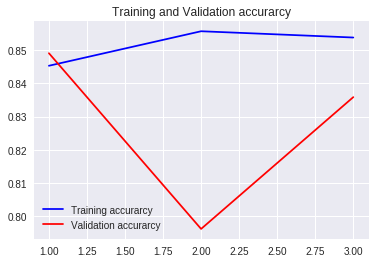

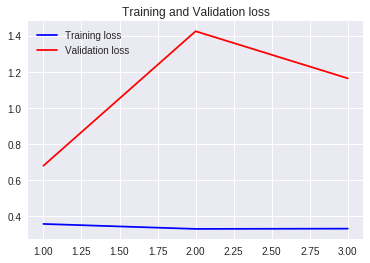

In [0]:
# plot the train and val curve
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [0]:
from vis.visualization import visualize_cam, visualize_activation, overlay, visualize_saliency
from vis.utils import utils
from keras import activations

def visualize_cam_heatmap(model, layer, index_val):
  
  from keras import backend as K
  import numpy as np
  
  index = index_val
  #layer_idx = utils.find_layer_idx(model, layer)
 # print(layer_idx)
  
  img = X_train[index] / 255

  #x = np.expand_dims(X_train[index] / 255, axis=0)

  heatmap = visualize_cam(model, -1, filter_indices = 0, seed_input = img)

  # first plot the base img
  plt.imshow(img)    

  # add gradient as overlay
  plt.imshow(heatmap,cmap='jet', alpha = 0.4)
  plt.title('CAM' + '(img_index=' + str(index) + ")")
  #plt.savefig('./heatmap_' + str(index) + '.jpg')

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten_1 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               7078400   
_________________________________________________________________
dense_23 (Dense)             (None, 1024)              525312    
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 1025      
Total params: 62,991,073
Trainable params: 8,654,337
Non-trainable params: 54,336,736
________________________________________________________

In [0]:
visualize_cam_heatmap(model.get_layer('inception_resnet_v2'), 'conv_7b', 400)

In [0]:
model.summary()
model.layers[-1]
model.get_layer('inception_resnet_v2').layers[-1]

In [0]:
def visualize_saliency_heatmap(model, layer, index_val):
  
  from keras import backend as K
  import numpy as np
  
  index = index_val
  layer_idx = utils.find_layer_idx(model, layer)
 # print(layer_idx)
  
  img = X_train[index] / 255

  #x = np.expand_dims(X_train[index] / 255, axis=0)

  heatmap = visualize_saliency(model, -1, filter_indices = 0, seed_input = img)
  
  # first plot the base img
  plt.imshow(img)

  # add gradient as overlay
  plt.imshow(heatmap,cmap='jet', alpha = 0.4)
  plt.title('saliency'+ '(img_index=' + str(index) + ')')


In [0]:
visualize_saliency_heatmap(model, 'dense_25', 300)

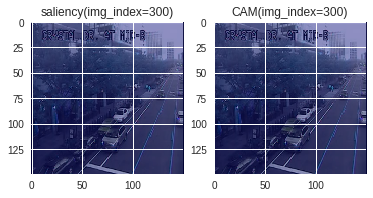

In [0]:
def visualize_heatmaps(model, last_conv, last_dense, index_val):
  plt.subplot(1, 2, 1)
  visualize_saliency_heatmap(model,last_dense,index_val)
  plt.subplot(1, 2, 2)
  visualize_cam_heatmap(model,last_conv, index_val)
  plt.savefig('./heatmaps_' + str(index_val) + ".jpg")

 
visualize_heatmaps(model, 'conv_7b', 'dense_159', 300)

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


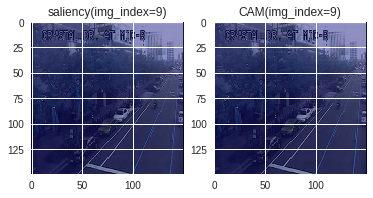

In [0]:
for i in range(1, 10):
  visualize_heatmaps(model, 'block8_10_conv', 'dense_159', i)

### Test Model

In [0]:
X_test, y_test = read_and_process_image(test_imgs)

X_test = np.array(X_test)
y_test = np.array(y_test)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow(X_test, y_test, batch_size=1)

ntest = len(X_test)

In [0]:
predict = model.predict_generator(test_generator, steps = ntest)

In [0]:
y_pred = predict > 0.5
y_true = y_test == 1

confusion_matrix(y_true, y_pred)

len(test_imgs)

report = metrics.classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.48      0.30      0.37      1325
        True       0.49      0.67      0.57      1325

   micro avg       0.48      0.48      0.48      2650
   macro avg       0.48      0.48      0.47      2650
weighted avg       0.48      0.48      0.47      2650



### Predict 10

In [0]:
X_test, y_test = read_and_process_image(test_imgs[0:10]) #Y_test in this case will be empty.
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

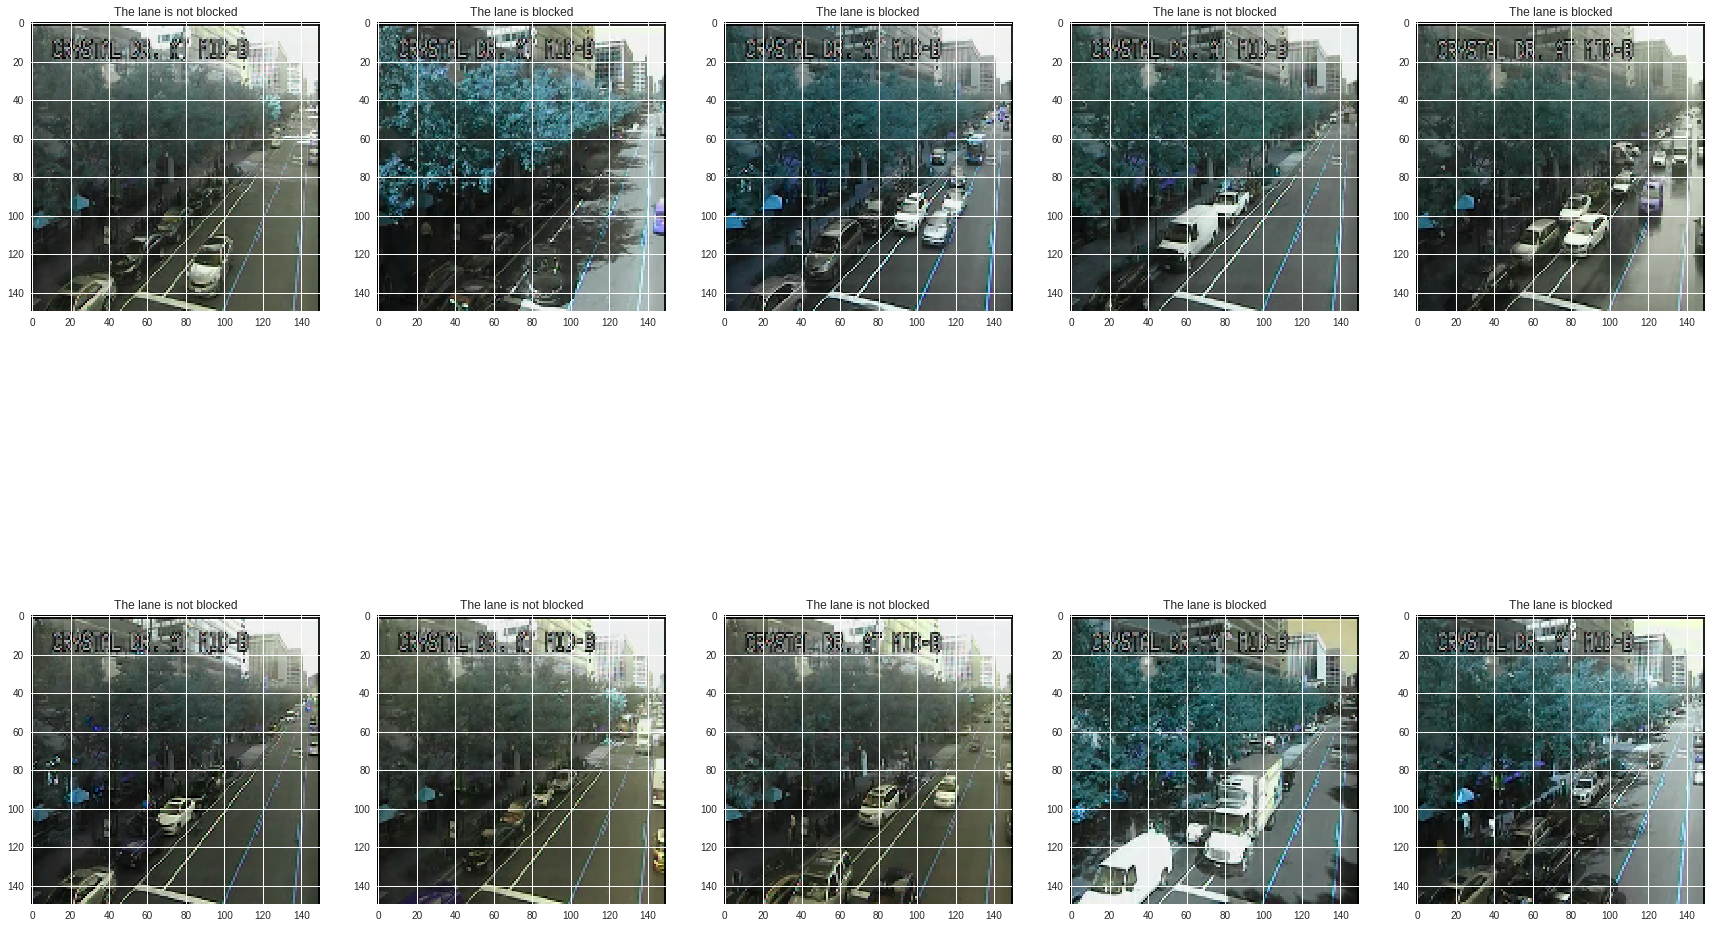

In [0]:
i = 0
text_labels = []
columns = 5
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x, batch_size=1):
    pred = model.predict(batch)
    if pred > 0.5:
        text_labels.append('not blocked')
    else:
        text_labels.append('blocked')
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('The lane is ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()

### Load Saved Model Weights

In [0]:
# from google.colab import files
model.save('run_foo.h5')
# files.download('run_foo.h5')

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________